In [17]:
!pip install optuna


   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------------------------------------- 0/4 [Mako]
   ---------- ----------------------------- 1/4 [colorlog]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np

In [3]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("data")

train = pd.read_csv(DATA_DIR / "train.csv")  # Kaggle'dan indirip data/ altına koy
test  = pd.read_csv(DATA_DIR / "test.csv")

print("train shape:", train.shape)
print("test  shape:", test.shape)

print("\nDTypes:\n", train.dtypes)

# Hedef var mı ve adı doğru mu?
assert "Calories" in train.columns, "Hedef sütun 'Calories' bulunamadı!"

# Eksik değer kontrolü
na_train = train.isna().sum().sort_values(ascending=False)
na_test  = test.isna().sum().sort_values(ascending=False)
print("\nNA - train:\n", na_train[na_train>0])
print("\nNA - test:\n", na_test[na_test>0])

# Sayısal sütunların hızlı istatistiği
num_cols = train.select_dtypes(include=["number"]).columns.tolist()
display(train[num_cols].describe().T)

# Kategorik sütunların eşsiz değer sayısı
cat_cols = train.select_dtypes(exclude=["number"]).columns.tolist()
for c in cat_cols:
    print(f"{c}: {train[c].nunique()} sınıf -> {sorted(train[c].dropna().unique())[:10]}")


train shape: (750000, 9)
test  shape: (250000, 8)

DTypes:
 id              int64
Sex            object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object

NA - train:
 Series([], dtype: int64)

NA - test:
 Series([], dtype: int64)


,count,mean,std,min,25%,50%,75%,max
id,750000.0,374999.500000,216506.495284,0.0,187499.75,374999.5,562499.25,749999.0
Age,750000.0,41.420404,15.175049,20.0,28.00,40.0,52.00,79.0
Height,750000.0,174.697685,12.824496,126.0,164.00,174.0,185.00,222.0
Weight,750000.0,75.145668,13.982704,36.0,63.00,74.0,87.00,132.0
Duration,750000.0,15.421015,8.354095,1.0,8.00,15.0,23.00,30.0
Heart_Rate,750000.0,95.483995,9.449845,67.0,88.00,95.0,103.00,128.0
Body_Temp,750000.0,40.036253,0.779875,37.1,39.60,40.3,40.70,41.5
Calories,750000.0,88.282781,62.395349,1.0,34.00,77.0,136.00,314.0


Sex: 2 sınıf -> ['female', 'male']


In [4]:
train.head(5)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


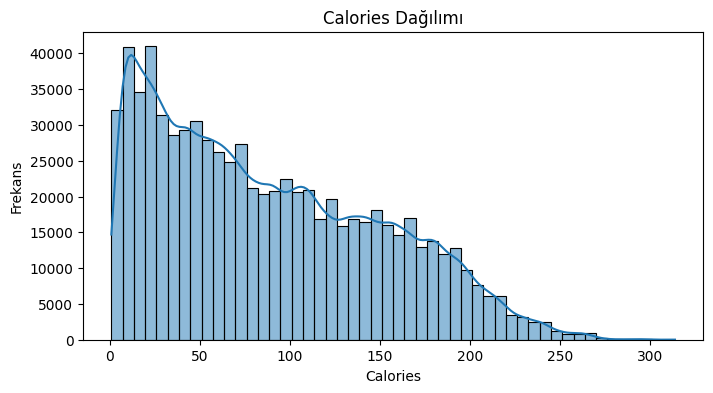

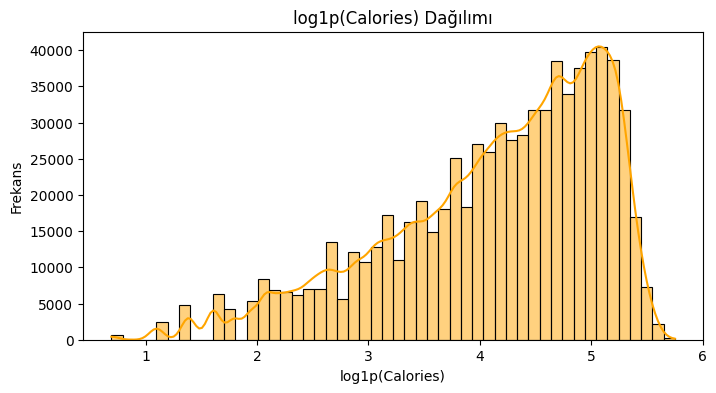

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(train["Calories"], bins=50, kde=True)
plt.title("Calories Dağılımı")
plt.xlabel("Calories")
plt.ylabel("Frekans")
plt.show()

# Log1p dönüşüm sonrası
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(train["Calories"]), bins=50, kde=True, color="orange")
plt.title("log1p(Calories) Dağılımı")
plt.xlabel("log1p(Calories)")
plt.ylabel("Frekans")
plt.show()


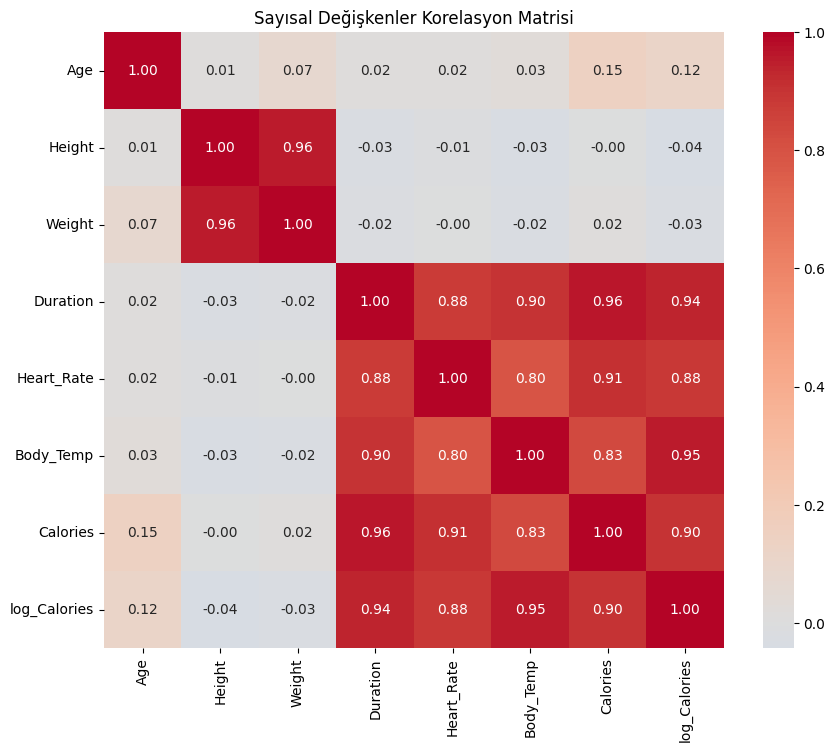

In [6]:
import numpy as np

# Hedefin log versiyonunu ekleyelim
train["log_Calories"] = np.log1p(train["Calories"])

# Sadece sayısal sütunlar
num_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories', 'log_Calories']

corr = train[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Sayısal Değişkenler Korelasyon Matrisi")
plt.show()


In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Hedef dönüşümü
y = np.log1p(train["Calories"])

# Özellikler
X = train.drop(columns=["Calories", "log_Calories", "id"])

# Sayısal & kategorik sütunlar
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

# Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("ridge", Ridge(alpha=1.0))
])

# CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error")

print("CV MSLE (log uzayında MSE):", -scores.mean())
print("CV RMSLE:", np.sqrt(-scores.mean()))


CV MSLE (log uzayında MSE): 0.032368847107999435
CV RMSLE: 0.17991344337764045


In [13]:
from sklearn.preprocessing import StandardScaler

preprocessor_scaled = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first"), cat_cols)
])

model_scaled = Pipeline([
    ("preprocess", preprocessor_scaled),
    ("ridge", Ridge(alpha=1.0))
])
scores = cross_val_score(model_scaled, X, y, cv=cv, scoring="neg_mean_squared_error")
print("Scaled CV MSLE:", -scores.mean(), " | RMSLE:", np.sqrt(-scores.mean()))

X_fe = X.copy()
X_fe["BMI"] = X["Weight"] / (X["Height"]/100.0)**2
X_fe["Intensity"] = X["Duration"] * X["Heart_Rate"]

num_cols_fe = X_fe.select_dtypes(include=["number"]).columns.tolist()
cat_cols_fe = X_fe.select_dtypes(exclude=["number"]).columns.tolist()

pre_fe = ColumnTransformer([
    ("num", StandardScaler(), num_cols_fe),
    ("cat", OneHotEncoder(drop="first"), cat_cols_fe)
])
model_fe = Pipeline([("preprocess", pre_fe), ("ridge", Ridge(alpha=1.0))])

scores = cross_val_score(model_fe, X_fe, y, cv=cv, scoring="neg_mean_squared_error")
print("FE CV MSLE:", -scores.mean(), " | RMSLE:", np.sqrt(-scores.mean()))


Scaled CV MSLE: 0.03236884709582001  | RMSLE: 0.17991344334379245
FE CV MSLE: 0.02224892198854201  | RMSLE: 0.14916072535537633


In [15]:
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

# 1) Özellik seti (FE dâhil)
X_fe = X.copy()
X_fe["BMI"] = X["Weight"] / (X["Height"]/100.0)**2
X_fe["Intensity"] = X["Duration"] * X["Heart_Rate"]

y = np.log1p(train["Calories"])  # log1p hedef (MSLE ile uyum)

num_cols = X_fe.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_fe.select_dtypes(exclude=["number"]).columns.tolist()  # ['Sex']

pre = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
])

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"  # y'yi log1p yaptığımız için MSE=MSLE mantığı
)

model = Pipeline([
    ("pre", pre),
    ("xgb", xgb)
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_fe, y, cv=cv, scoring="neg_mean_squared_error")
print("XGB (OHE) CV MSLE:", -scores.mean(), "| RMSLE:", np.sqrt(-scores.mean()))


XGB (OHE) CV MSLE: 0.003646572617732093 | RMSLE: 0.06038685798857309


In [18]:
# 1) Kurulum (gerekirse)
# pip install optuna xgboost

import optuna
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# === FE: aynı set (BMI + Intensity) ===
X_fe = X.copy()
X_fe["BMI"] = X["Weight"] / (X["Height"]/100.0)**2
X_fe["Intensity"] = X["Duration"] * X["Heart_Rate"]

y = np.log1p(train["Calories"])

num_cols = X_fe.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_fe.select_dtypes(exclude=["number"]).columns.tolist()  # ['Sex']

pre = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial: optuna.Trial):
    # --- Arama alanları ---
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),  # L2
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1.0, log=True),     # L1
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),                         # node split cezası
        "random_state": 42,
        "n_jobs": -1,
        "objective": "reg:squarederror",
        "tree_method": "hist",   # hızlı ve genellikle yeterli
    }

    model = Pipeline([
        ("pre", pre),
        ("xgb", XGBRegressor(**params))
    ])

    # Negatif MSE dönüyor → işaretini çeviriyoruz
    scores = cross_val_score(model, X_fe, y, cv=cv, scoring="neg_mean_squared_error")
    msle = -scores.mean()
    return msle

# === Çalıştır ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, show_progress_bar=True)  # önce 20 deneme; iyi giderse 50-100'e çıkar
print("Best MSLE:", study.best_value)
print("Best params:", study.best_params)


C:\Users\ahmet\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-14 18:28:56,079] A new study created in memory with name: no-name-e67e4510-94a7-4b2c-a3cc-fb8d106af884
Best trial: 0. Best value: 0.00394684:   5%|██▏                                        | 1/20 [02:36<49:38, 156.76s/it]

[I 2025-08-14 18:31:32,841] Trial 0 finished with value: 0.003946839456308322 and parameters: {'n_estimators': 639, 'learning_rate': 0.013973404928436654, 'max_depth': 7, 'min_child_weight': 7.096559906702608, 'subsample': 0.9114798245090314, 'colsample_bytree': 0.6496803899127742, 'reg_lambda': 0.024080245078418976, 'reg_alpha': 0.23906218913360724, 'gamma': 2.062340357007239}. Best is trial 0 with value: 0.003946839456308322.


Best trial: 0. Best value: 0.00394684:  10%|████▎                                      | 2/20 [03:47<31:50, 106.16s/it]

[I 2025-08-14 18:32:43,586] Trial 1 finished with value: 0.004023474604469815 and parameters: {'n_estimators': 533, 'learning_rate': 0.235378824623979, 'max_depth': 10, 'min_child_weight': 1.8293676747398764, 'subsample': 0.8073093973410206, 'colsample_bytree': 0.9198891015583133, 'reg_lambda': 1.8526809424589183, 'reg_alpha': 0.027994512791745866, 'gamma': 2.383547519627522}. Best is trial 0 with value: 0.003946839456308322.


Best trial: 0. Best value: 0.00394684:  15%|██████▍                                    | 3/20 [05:58<33:18, 117.56s/it]

[I 2025-08-14 18:34:54,718] Trial 2 finished with value: 0.00441985806597998 and parameters: {'n_estimators': 1085, 'learning_rate': 0.11875052721206633, 'max_depth': 4, 'min_child_weight': 3.801708486259848, 'subsample': 0.7637261733542555, 'colsample_bytree': 0.8417232042542564, 'reg_lambda': 0.28661998876502887, 'reg_alpha': 0.01077156241814639, 'gamma': 3.250103919159426}. Best is trial 0 with value: 0.003946839456308322.


Best trial: 3. Best value: 0.00382901:  20%|████████▌                                  | 4/20 [07:34<29:05, 109.12s/it]

[I 2025-08-14 18:36:30,894] Trial 3 finished with value: 0.0038290062703912275 and parameters: {'n_estimators': 668, 'learning_rate': 0.04711624300904341, 'max_depth': 6, 'min_child_weight': 5.7550519899029515, 'subsample': 0.8923806551689573, 'colsample_bytree': 0.7542217049502085, 'reg_lambda': 0.04570173091824532, 'reg_alpha': 0.0016894575385836999, 'gamma': 0.8493614902676833}. Best is trial 3 with value: 0.0038290062703912275.


Best trial: 3. Best value: 0.00382901:  25%|██████████▊                                | 5/20 [09:06<25:43, 102.88s/it]

[I 2025-08-14 18:38:02,717] Trial 4 finished with value: 0.003906415205235785 and parameters: {'n_estimators': 783, 'learning_rate': 0.14487738396325026, 'max_depth': 10, 'min_child_weight': 8.829561645221267, 'subsample': 0.9732073246021815, 'colsample_bytree': 0.8341436780782328, 'reg_lambda': 0.12686601077000956, 'reg_alpha': 0.4404592057717154, 'gamma': 2.6581769655710614}. Best is trial 3 with value: 0.0038290062703912275.


Best trial: 3. Best value: 0.00382901:  30%|█████████████▏                              | 6/20 [10:40<23:18, 99.90s/it]

[I 2025-08-14 18:39:36,815] Trial 5 finished with value: 0.003985499641917132 and parameters: {'n_estimators': 643, 'learning_rate': 0.037117339494059196, 'max_depth': 7, 'min_child_weight': 9.653016040692208, 'subsample': 0.9980572075659931, 'colsample_bytree': 0.7574989263001297, 'reg_lambda': 1.3294329095675188, 'reg_alpha': 0.01886619326877194, 'gamma': 4.4298420224940065}. Best is trial 3 with value: 0.0038290062703912275.


Best trial: 3. Best value: 0.00382901:  35%|███████████████                            | 7/20 [12:40<23:01, 106.30s/it]

[I 2025-08-14 18:41:36,289] Trial 6 finished with value: 0.004826352656404876 and parameters: {'n_estimators': 1077, 'learning_rate': 0.1678136378923708, 'max_depth': 4, 'min_child_weight': 1.8383151779457945, 'subsample': 0.8821104827944476, 'colsample_bytree': 0.6632352486685992, 'reg_lambda': 6.185387415850634, 'reg_alpha': 0.057797930838825354, 'gamma': 3.362587083825651}. Best is trial 3 with value: 0.0038290062703912275.


Best trial: 3. Best value: 0.00382901:  40%|█████████████████▏                         | 8/20 [14:32<21:38, 108.18s/it]

[I 2025-08-14 18:43:28,497] Trial 7 finished with value: 0.003968952065371052 and parameters: {'n_estimators': 977, 'learning_rate': 0.13110228641923355, 'max_depth': 7, 'min_child_weight': 2.476743209757542, 'subsample': 0.9050902434518324, 'colsample_bytree': 0.8874537874883015, 'reg_lambda': 0.17560205328371964, 'reg_alpha': 0.033698571531337596, 'gamma': 3.0160396686586397}. Best is trial 3 with value: 0.0038290062703912275.


Best trial: 3. Best value: 0.00382901:  45%|███████████████████▊                        | 9/20 [15:41<17:35, 95.98s/it]

[I 2025-08-14 18:44:37,646] Trial 8 finished with value: 0.004264605721609525 and parameters: {'n_estimators': 525, 'learning_rate': 0.07968194448369885, 'max_depth': 5, 'min_child_weight': 1.760580056637963, 'subsample': 0.8640762532344632, 'colsample_bytree': 0.7396078126957039, 'reg_lambda': 0.0025155885125927933, 'reg_alpha': 0.03945536529449527, 'gamma': 3.3844997212095747}. Best is trial 3 with value: 0.0038290062703912275.


Best trial: 3. Best value: 0.00382901:  50%|█████████████████████▌                     | 10/20 [17:23<16:16, 97.67s/it]

[I 2025-08-14 18:46:19,104] Trial 9 finished with value: 0.003928405501957531 and parameters: {'n_estimators': 567, 'learning_rate': 0.026974286161043196, 'max_depth': 10, 'min_child_weight': 9.1947838046442, 'subsample': 0.6486838403231757, 'colsample_bytree': 0.8613258239435946, 'reg_lambda': 0.16309082563326568, 'reg_alpha': 0.7242457871704095, 'gamma': 2.916869817759657}. Best is trial 3 with value: 0.0038290062703912275.


Best trial: 10. Best value: 0.00374285:  55%|██████████████████████▌                  | 11/20 [20:38<19:07, 127.45s/it]

[I 2025-08-14 18:49:34,090] Trial 10 finished with value: 0.0037428506398711203 and parameters: {'n_estimators': 849, 'learning_rate': 0.010887205100897189, 'max_depth': 6, 'min_child_weight': 5.55749124173857, 'subsample': 0.7016558912574165, 'colsample_bytree': 0.9912460996626996, 'reg_lambda': 0.011178066307243677, 'reg_alpha': 0.0010943261230693178, 'gamma': 0.31598763283048914}. Best is trial 10 with value: 0.0037428506398711203.


Best trial: 10. Best value: 0.00374285:  60%|████████████████████████▌                | 12/20 [22:13<15:42, 117.87s/it]

[I 2025-08-14 18:51:10,036] Trial 11 finished with value: 0.005474205409224908 and parameters: {'n_estimators': 341, 'learning_rate': 0.01022289984062087, 'max_depth': 6, 'min_child_weight': 5.854205384967889, 'subsample': 0.6754203431682025, 'colsample_bytree': 0.9899858492204381, 'reg_lambda': 0.009893293919388394, 'reg_alpha': 0.0010282755428485603, 'gamma': 0.08465069642938494}. Best is trial 10 with value: 0.0037428506398711203.


Best trial: 12. Best value: 0.00365365:  65%|██████████████████████████▋              | 13/20 [24:52<15:11, 130.18s/it]

[I 2025-08-14 18:53:48,543] Trial 12 finished with value: 0.003653652593193979 and parameters: {'n_estimators': 859, 'learning_rate': 0.02029607436498758, 'max_depth': 8, 'min_child_weight': 4.8538336172919685, 'subsample': 0.723382824544614, 'colsample_bytree': 0.9963914322824253, 'reg_lambda': 0.022028015312687485, 'reg_alpha': 0.0011727549033278633, 'gamma': 0.41867645997199876}. Best is trial 12 with value: 0.003653652593193979.


Best trial: 12. Best value: 0.00365365:  70%|████████████████████████████▋            | 14/20 [27:15<13:24, 134.03s/it]

[I 2025-08-14 18:56:11,473] Trial 13 finished with value: 0.003751845190744527 and parameters: {'n_estimators': 838, 'learning_rate': 0.02169035868808029, 'max_depth': 8, 'min_child_weight': 4.073023347978978, 'subsample': 0.710078793500239, 'colsample_bytree': 0.9986550166738528, 'reg_lambda': 0.0011316942638057448, 'reg_alpha': 0.003880629164260579, 'gamma': 1.2223930982471203}. Best is trial 12 with value: 0.003653652593193979.


Best trial: 14. Best value: 0.00358529:  75%|██████████████████████████████▊          | 15/20 [30:40<12:57, 155.42s/it]

[I 2025-08-14 18:59:36,481] Trial 14 finished with value: 0.0035852946009666984 and parameters: {'n_estimators': 925, 'learning_rate': 0.016542397218826395, 'max_depth': 8, 'min_child_weight': 7.2374246462151275, 'subsample': 0.7341082353493036, 'colsample_bytree': 0.941487063401131, 'reg_lambda': 0.008991254953513815, 'reg_alpha': 0.003552950464837585, 'gamma': 0.05703718469813068}. Best is trial 14 with value: 0.0035852946009666984.


Best trial: 14. Best value: 0.00358529:  80%|████████████████████████████████▊        | 16/20 [33:22<10:29, 157.30s/it]

[I 2025-08-14 19:02:18,144] Trial 15 finished with value: 0.0037529100718215204 and parameters: {'n_estimators': 932, 'learning_rate': 0.01882271149906141, 'max_depth': 8, 'min_child_weight': 7.3241192692269586, 'subsample': 0.6194677152978505, 'colsample_bytree': 0.9417042428787089, 'reg_lambda': 0.0049963793794097645, 'reg_alpha': 0.004922953377955917, 'gamma': 1.1806571050550128}. Best is trial 14 with value: 0.0035852946009666984.


Best trial: 14. Best value: 0.00358529:  85%|██████████████████████████████████▊      | 17/20 [36:03<07:55, 158.51s/it]

[I 2025-08-14 19:04:59,465] Trial 16 finished with value: 0.0037957903761888846 and parameters: {'n_estimators': 1156, 'learning_rate': 0.029587153466510665, 'max_depth': 9, 'min_child_weight': 7.7860476095272855, 'subsample': 0.7629628283887201, 'colsample_bytree': 0.9440557746739477, 'reg_lambda': 0.02333180459287822, 'reg_alpha': 0.0034641380869187763, 'gamma': 1.8499363934634026}. Best is trial 14 with value: 0.0035852946009666984.


Best trial: 14. Best value: 0.00358529:  90%|████████████████████████████████████▉    | 18/20 [38:07<04:56, 148.12s/it]

[I 2025-08-14 19:07:03,384] Trial 17 finished with value: 0.0036929152446961745 and parameters: {'n_estimators': 920, 'learning_rate': 0.05536475183080687, 'max_depth': 8, 'min_child_weight': 3.9801346683819796, 'subsample': 0.7384537678940679, 'colsample_bytree': 0.9108575681760297, 'reg_lambda': 0.05336449471717976, 'reg_alpha': 0.008370059959447401, 'gamma': 0.6215858617146952}. Best is trial 14 with value: 0.0035852946009666984.


Best trial: 14. Best value: 0.00358529:  95%|██████████████████████████████████████▉  | 19/20 [41:14<02:39, 159.76s/it]

[I 2025-08-14 19:10:10,268] Trial 18 finished with value: 0.0037582994077985424 and parameters: {'n_estimators': 1010, 'learning_rate': 0.016389404978885976, 'max_depth': 9, 'min_child_weight': 4.696535121139707, 'subsample': 0.8112194985250543, 'colsample_bytree': 0.958015043862188, 'reg_lambda': 0.003176926532361744, 'reg_alpha': 0.13664367178762132, 'gamma': 1.526423766982}. Best is trial 14 with value: 0.0035852946009666984.


Best trial: 14. Best value: 0.00358529: 100%|█████████████████████████████████████████| 20/20 [44:52<00:00, 134.62s/it]

[I 2025-08-14 19:13:48,386] Trial 19 finished with value: 0.003686870119348417 and parameters: {'n_estimators': 733, 'learning_rate': 0.06841260502131333, 'max_depth': 9, 'min_child_weight': 6.420483828731528, 'subsample': 0.6062440396358838, 'colsample_bytree': 0.8103068786684194, 'reg_lambda': 0.46885071008525453, 'reg_alpha': 0.001985824756270722, 'gamma': 0.0008871975044162372}. Best is trial 14 with value: 0.0035852946009666984.
Best MSLE: 0.0035852946009666984
Best params: {'n_estimators': 925, 'learning_rate': 0.016542397218826395, 'max_depth': 8, 'min_child_weight': 7.2374246462151275, 'subsample': 0.7341082353493036, 'colsample_bytree': 0.941487063401131, 'reg_lambda': 0.008991254953513815, 'reg_alpha': 0.003552950464837585, 'gamma': 0.05703718469813068}


In [19]:
best_params = study.best_params
best_params.update({
    "random_state": 42,
    "n_jobs": -1,
    "objective": "reg:squarederror",
    "tree_method": "hist",
})

best_model = Pipeline([
    ("pre", pre),
    ("xgb", XGBRegressor(**best_params))
])

# CV ile doğrula
scores = cross_val_score(best_model, X_fe, y, cv=cv, scoring="neg_mean_squared_error")
best_msle = -scores.mean()
best_rmsle = np.sqrt(best_msle)
print(f"CV MSLE: {best_msle:.6f} | CV RMSLE: {best_rmsle:.6f}")


CV MSLE: 0.003585 | CV RMSLE: 0.059877


In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb  # <-- Booster API'yi kullanacağız

# ==========
# Veri & FE
# ==========
X = train.drop(columns=["Calories", "id"]).copy()
y_log = np.log1p(train["Calories"]).values

X["BMI"] = X["Weight"] / (X["Height"]/100.0)**2
X["Intensity"] = X["Duration"] * X["Heart_Rate"]

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

pre = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
])

def make_bins(y, n_bins=30):
    return pd.qcut(y, q=n_bins, labels=False, duplicates='drop').astype(int)

y_bins = make_bins(y_log, n_bins=30)

# ===========================
# CV + early stopping (train)
# ===========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_msle, fold_rmsle = [], []

# XGBoost parametreleri (Booster API formatı)
xgb_params = {
    "objective": "reg:squarederror",  # log-uzayında MSE = MSLE
    "eval_metric": "rmse",            # log-uzayında RMSE = RMSLE yorumu
    "eta": 0.02,                      # learning_rate
    "max_depth": 8,
    "min_child_weight": 7.0,
    "subsample": 0.75,
    "colsample_bytree": 0.9,
    "lambda": 0.05,                   # reg_lambda
    "alpha": 0.003,                   # reg_alpha
    "gamma": 0.1,
    "tree_method": "hist",
    "seed": 42,
}

num_boost_round = 2000
early_stopping_rounds = 100

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y_bins), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y_log[tr_idx], y_log[va_idx]

    # sızıntısız OHE
    pre.fit(X_tr)
    X_tr_t = pre.transform(X_tr)   # numpy array veya CSR sparse döner
    X_va_t = pre.transform(X_va)

    # DMatrix (sparse desteklenir)
    dtrain = xgb.DMatrix(X_tr_t, label=y_tr)
    dvalid = xgb.DMatrix(X_va_t, label=y_va)

    # train + early stopping
    booster = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dvalid, "valid")],
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=False
    )

    # en iyi iterasyonda tahmin
    try:
        y_va_pred = booster.predict(dvalid, iteration_range=(0, booster.best_iteration + 1))
    except TypeError:
        # eski xgboost sürümleri için
        y_va_pred = booster.predict(dvalid, ntree_limit=booster.best_ntree_limit)

    msle = float(np.mean((y_va - y_va_pred) ** 2))
    rmsle = float(np.sqrt(msle))
    fold_msle.append(msle)
    fold_rmsle.append(rmsle)

    print(f"[Fold {fold}] best_iter={getattr(booster, 'best_iteration', None)}  MSLE={msle:.6f}  RMSLE={rmsle:.6f}")

print("\nCV MSLE:", np.mean(fold_msle), " | CV RMSLE:", np.mean(fold_rmsle))


[Fold 1] best_iter=727  MSLE=0.000125  RMSLE=0.011198
[Fold 2] best_iter=604  MSLE=0.000136  RMSLE=0.011644
[Fold 3] best_iter=699  MSLE=0.000139  RMSLE=0.011808
[Fold 4] best_iter=1239  MSLE=0.000137  RMSLE=0.011701
[Fold 5] best_iter=618  MSLE=0.000136  RMSLE=0.011680

CV MSLE: 0.00013474994530417257  | CV RMSLE: 0.011606260526753218


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

RNG = 42

# ------- veri & hedef (log1p) -------
X = train.drop(columns=["Calories", "id"]).copy()
y_log = np.log1p(train["Calories"]).values

# FE
X["BMI"] = X["Weight"] / (X["Height"]/100.0)**2
X["Intensity"] = X["Duration"] * X["Heart_Rate"]

# sütunlar ve OHE
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

pre = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
])

# stratify için log hedefi kuantile bin'le
def make_bins(y, n_bins=30):
    return pd.qcut(y, q=n_bins, labels=False, duplicates='drop').astype(int)

bins = make_bins(y_log, n_bins=30)

# ------- hold-out split (stratified) -------
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y_log, test_size=0.2, random_state=RNG, stratify=bins
)

# sızıntısız OHE
pre.fit(X_tr)
X_tr_t = pre.transform(X_tr)
X_va_t = pre.transform(X_va)

# xgb parametreleri (CV'de kullandıklarınla aynı bölgede tut)
params = {
    "objective": "reg:squarederror",  # log-uzayında MSE = MSLE
    "eval_metric": "rmse",            # log-uzayında RMSE = RMSLE yorumu
    "eta": 0.02,
    "max_depth": 8,
    "min_child_weight": 7.0,
    "subsample": 0.75,
    "colsample_bytree": 0.9,
    "lambda": 0.05,
    "alpha": 0.003,
    "gamma": 0.1,
    "tree_method": "hist",
    "seed": RNG,
}

dtrain = xgb.DMatrix(X_tr_t, label=y_tr)
dvalid = xgb.DMatrix(X_va_t, label=y_va)

num_boost_round = 2000
es_rounds = 100

booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=[(dvalid, "valid")],
    early_stopping_rounds=es_rounds,
    verbose_eval=False
)

# en iyi iterasyonda tahmin
try:
    y_pred = booster.predict(dvalid, iteration_range=(0, booster.best_iteration + 1))
except TypeError:
    y_pred = booster.predict(dvalid, ntree_limit=booster.best_ntree_limit)

msle_holdout = float(np.mean((y_va - y_pred) ** 2))
rmsle_holdout = float(np.sqrt(msle_holdout))
print(f"[HOLD-OUT] best_iter={getattr(booster, 'best_iteration', None)}  MSLE={msle_holdout:.6f}  RMSLE={rmsle_holdout:.6f}")


[HOLD-OUT] best_iter=510  MSLE=0.000138  RMSLE=0.011752


In [15]:
# hedefi karıştır (etiketleri bozalım)
y_log_shuffled = np.random.RandomState(RNG).permutation(y_log)

# stratify için yine log hedefin bin'leri (karışık hedefe göre stratify etmeye gerek yok;
# ama dağılımsal denge için aynı bins'i kullanabiliriz)
X_tr_s, X_va_s, y_tr_s, y_va_s = train_test_split(
    X, y_log_shuffled, test_size=0.2, random_state=RNG, stratify=bins
)

# sızıntısız OHE (yeniden fit!)
pre.fit(X_tr_s)
X_tr_s_t = pre.transform(X_tr_s)
X_va_s_t = pre.transform(X_va_s)

dtrain_s = xgb.DMatrix(X_tr_s_t, label=y_tr_s)
dvalid_s = xgb.DMatrix(X_va_s_t, label=y_va_s)

booster_s = xgb.train(
    params=params,
    dtrain=dtrain_s,
    num_boost_round=num_boost_round,
    evals=[(dvalid_s, "valid")],
    early_stopping_rounds=es_rounds,
    verbose_eval=False
)

try:
    y_pred_s = booster_s.predict(dvalid_s, iteration_range=(0, booster_s.best_iteration + 1))
except TypeError:
    y_pred_s = booster_s.predict(dvalid_s, ntree_limit=booster_s.best_ntree_limit)

msle_shuffle = float(np.mean((y_va_s - y_pred_s) ** 2))
rmsle_shuffle = float(np.sqrt(msle_shuffle))
print(f"[SHUFFLE] best_iter={getattr(booster_s, 'best_iteration', None)}  MSLE={msle_shuffle:.4f}  RMSLE={rmsle_shuffle:.4f}")


[SHUFFLE] best_iter=2  MSLE=0.9348  RMSLE=0.9669


In [17]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

# ===== 1) Veri yükleme =====
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# ===== 2) Hedef ve özellikler =====
X_train = train.drop(columns=["Calories", "id"]).copy()
y_train_log = np.log1p(train["Calories"]).values
X_test = test.drop(columns=["id"]).copy()

# ===== 3) Feature Engineering =====
for df in [X_train, X_test]:
    df["BMI"] = df["Weight"] / (df["Height"]/100.0)**2
    df["Intensity"] = df["Duration"] * df["Heart_Rate"]

# ===== 4) Sütun tipleri =====
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

# ===== 5) Ön-işleme =====
pre = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
])

X_train_t = pre.fit_transform(X_train)
X_test_t = pre.transform(X_test)

# ===== 6) Model =====
model = XGBRegressor(
    n_estimators=900,              # CV'deki best_iter ortalaması civarı
    learning_rate=0.02,
    max_depth=8,
    min_child_weight=7.0,
    subsample=0.75,
    colsample_bytree=0.9,
    reg_lambda=0.05,
    reg_alpha=0.003,
    gamma=0.1,
    objective="reg:squarederror",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

# ===== 7) Fit =====
model.fit(X_train_t, y_train_log)

# ===== 8) Test tahmini =====
y_pred_log = model.predict(X_test_t)
y_pred = np.expm1(y_pred_log)  # log1p ters dönüşüm

# ===== 9) Submission =====
submission = pd.DataFrame({
    "id": test["id"],
    "Calories": y_pred
})
submission.to_csv("submission.csv", index=False)

print("submission.csv oluşturuldu ✅")


submission.csv oluşturuldu ✅
